In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('EMData.txt', sep=" ", header=None)
data.columns = ["_", "x", "y"]
x = data.drop('_', axis=1)

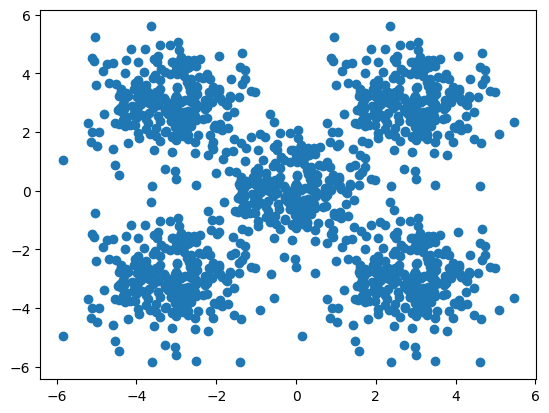

In [3]:
plt.scatter(data['x'], data['y'])
plt.show()

In [4]:
def euclidean_dis(x,mu_x):
    return np.sqrt(x**2 + mu_x**2)

## Kmeans

### 1) Finish simple_Kmean

In [5]:
def simple_Kmean(X, n_cluster, iters, seed=2):
    if seed != 2:
        np.random.seed(seed)
    else:
        np.random.seed(2)
    data = X.copy()
    data['clusters'] = np.random.choice(np.arange(1,n_cluster+1), len(data))

    for _ in range(iters):
        cluster_means = data.groupby('clusters').mean()
        for i in range(len(data)):
            distances = [euclidean_dis(data.iloc[i]['x'] - cluster_means.loc[c,'x'],
                                        data.iloc[i]['y'] - cluster_means.loc[c,'y']) 
                                        for c, _ in cluster_means.iterrows()]
            data.at[i, 'clusters'] = np.argmin(distances) + 1

    return data, cluster_means

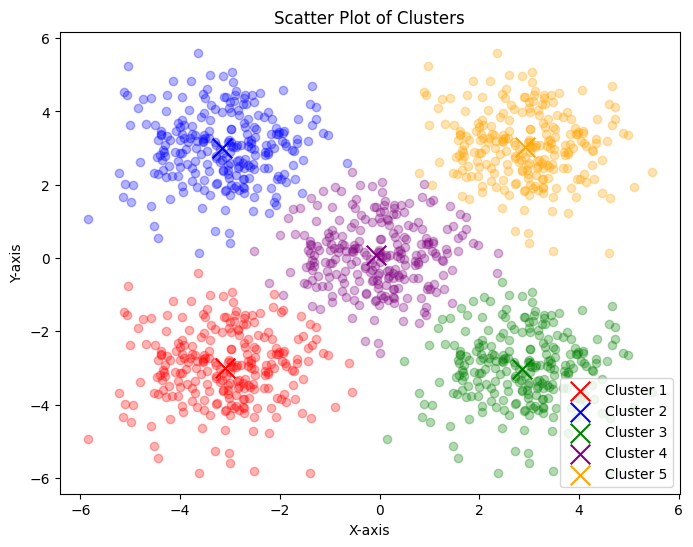

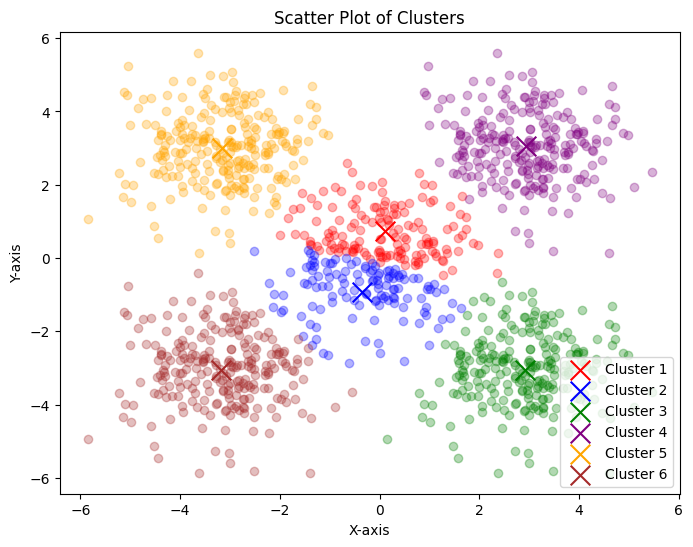

In [6]:
class_colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'purple', 4: 'orange', 5: 'brown'}
def plot_km(km):
    X, _ = km
    plt.figure(figsize=(8, 6))
    count = 0
    for cluster in np.sort(X['clusters'].unique()):
        cluster_data = X[X['clusters'] == cluster]
        plt.scatter(cluster_data['x'], cluster_data['y'], alpha=0.3, c=class_colors[count])
        plt.scatter(cluster_data['x'].mean(), cluster_data['y'].mean(), label=f'Cluster {cluster}', marker = 'x', s=200, c=class_colors[count])
        count +=1
    
    plt.title('Scatter Plot of Clusters')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend(loc = 'lower right')
    plt.show()

plot_km(simple_Kmean(x, 5, 10))
plot_km(simple_Kmean(x, 6, 10))

### 2) Inertia and Within cluster variance

In [7]:
def calc_inertia(km):
    data, cluster_means = km
    inertia = 0.0
    cvariance = []
    for i in range(len(data)):
        cluster_center = cluster_means.loc[data.at[i, 'clusters']]
        inertia += euclidean_dis(data.at[i, 'x'] - cluster_center['x'], data.at[i, 'y'] - cluster_center['y'])**2
        cvariance.append(euclidean_dis(data.at[i, 'x'] - cluster_center['x'], data.at[i, 'y'] - cluster_center['y'])**2)
    cvariance = np.array(cvariance).mean()
    return inertia, cvariance

### 3) Average Inertia and within cluster variance with k=6

In [8]:
within_cluster_variance = []
inertias = []
for _ in range(10):
    inertia, variance = calc_inertia(simple_Kmean(x, 6, 10, None))
    within_cluster_variance.append(variance)
    inertias.append(inertia)
within_cluster_variance = np.array(within_cluster_variance)
inertias = np.array(inertias)
print(f'\nMean Within cluster variance:\n{within_cluster_variance.mean()}')
print(f'\nMean Inertia:\n{inertias.mean()}')


Mean Within cluster variance:
1.719394715005119

Mean Inertia:
2149.2433937563974


### 4) Value of k using elbow method

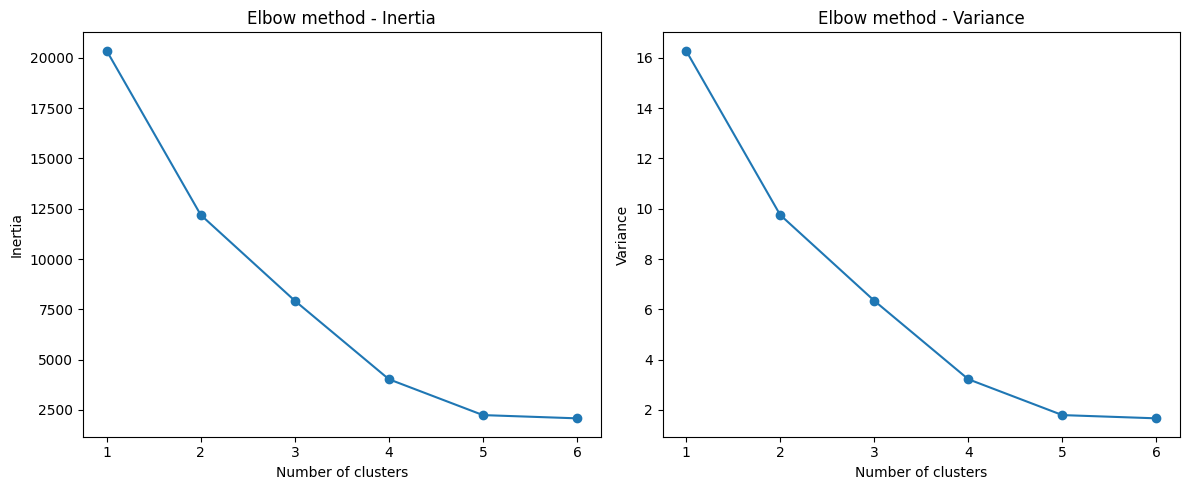

In [9]:
import matplotlib.pyplot as plt

def plot_inertia(X, km, n_cluster_range, iters):
    inertias = []
    variances = []
    for i in range(1, n_cluster_range+1):
        result = calc_inertia(km(X, i, iters=iters))
        inertias.append(result[0])
        variances.append(result[1])

    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.plot(range(1, len(inertias) + 1), inertias, marker='o')
    ax1.set_title('Elbow method - Inertia')
    ax1.set_xlabel('Number of clusters')
    ax1.set_ylabel('Inertia')

    ax2.plot(range(1, len(variances) + 1), variances, marker='o')
    ax2.set_title('Elbow method - Variance')
    ax2.set_xlabel('Number of clusters')
    ax2.set_ylabel('Variance')

    plt.tight_layout()
    plt.show()

plot_inertia(x, simple_Kmean, 6, 10)


From the above plots, we can say that k = 5 is the best value of k, while k=6 is okay too. When k = 5, clusters formed have similar sizes contrary to when k = 6.

## EM Algorithm

### 1) Completing funcs in class notebook

In [10]:
def gaussian(X, mu, cov):
    n = X.shape[1]
    diff = (X - mu).T
    return np.diagonal(1 / ((2 * np.pi) ** (n / 2) * np.linalg.det(cov) ** 0.5) 
                       * np.exp(-0.5 * np.dot(np.dot(diff.T, np.linalg.inv(cov)), 
                                              diff))).reshape(-1, 1)

In [11]:
def initialize_clusters(X, n_clusters):
    clusters = []
    
    # We use the KMeans centroids to initialise the GMM
    
    _, means = simple_Kmean(x, 6, 10, 2)
    means = means.values
    
    for i in range(n_clusters):
        clusters.append({
            'pi_k': 1.0 / n_clusters,
            'mu_k': means[i],
            'cov_k': np.identity(X.shape[1], dtype=np.float64)
        })
        
    return clusters

In [12]:
def expectation_step(X, clusters):
    global gamma_nk, totals

    num_points = X.shape[0]
    num_clusters = len(clusters)    
    gamma_nk = np.zeros((num_points, num_clusters))
    
    for k in range(num_clusters):
        pi_k = clusters[k]['pi_k']
        mu_k = clusters[k]['mu_k']
        cov_k = clusters[k]['cov_k']

        gaussian(X, mu=mu_k, cov=cov_k) * 2
        gamma_nk[:, k] = pi_k * gaussian(X, mu=mu_k, cov=cov_k).squeeze()

    totals = np.sum(gamma_nk, axis=1, keepdims=True)
    gamma_nk = gamma_nk/totals

In [13]:
def maximization_step(X, clusters):
    global gamma_nk
    
    num_points = X.shape[0]
    num_clusters = len(clusters)

    for k in range(num_clusters):
        clusters[k]['pi_k'] = np.sum(gamma_nk[:, k]) / num_points
        clusters[k]['mu_k'] = np.sum(gamma_nk[:, k].reshape(-1, 1) * X, axis=0).values / np.sum(gamma_nk[:, k])
        diff = X - clusters[k]['mu_k']
        clusters[k]['cov_k'] = np.dot((gamma_nk[:, k].reshape(-1, 1) * diff).T, diff) / np.sum(gamma_nk[:, k])

    return clusters


In [14]:
def get_likelihood(X, clusters):
    global gamma_nk, totals
    
    likelihood = 0.0
    num_points = X.shape[0]
    num_clusters = len(clusters)

    for _ in range(num_points):
        point_likelihood = 0.0
        for k in range(num_clusters):
            pi_k = clusters[k]['pi_k']
            mu_k = clusters[k]['mu_k']
            cov_k = clusters[k]['cov_k']
            point_likelihood += pi_k * gaussian(X.values[k].reshape(-1,1).T, mu=mu_k, cov=cov_k)

        likelihood += np.log(point_likelihood)

    return likelihood

### 2) Combining functions to train and fit the data

In [15]:
def train_gmm(x, n_clusters, n_epochs):
    clusters = initialize_clusters(x, n_clusters)
    likelihoods = np.zeros((n_epochs, ))
    scores = np.zeros((x.shape[0], n_clusters))
    sample_likelihoods = np.zeros((x.shape[0],))
    history = []

    for i in range(n_epochs):
        clusters_snapshot = []
        expectation_step(x, clusters)
        clusters = maximization_step(x, clusters)
        likelihood = get_likelihood(x, clusters)
        likelihoods[i] = likelihood[0][0]
        sample_likelihoods = np.sum(gamma_nk * np.log(gamma_nk + 1e-10), axis=1) # add a small num to prevent log div by 0
        clusters_snapshot.append([cluster.copy() for cluster in clusters])
        history.append(clusters_snapshot)

        if (i+1)%10 == 0:
            print('Epoch: ', i + 1, 'Likelihood: ', likelihood[0][0])

    scores = np.log(gamma_nk + 1e-10)

    return clusters, likelihoods, scores, sample_likelihoods, history

In [16]:
def plot_gaus(clusters, scores):
    classes = []
    plt.figure(figsize=(8, 6))
    plt.tight_layout
    for i in scores:
        classes.append(i.argmax())

    plotx=pd.DataFrame(x)
    plotx.columns=['x','y']

    count = 0
    for i in clusters:
        plt.scatter(i['mu_k'][0],i['mu_k'][1], marker= 'x', s=200, c=class_colors[count], label = f'Cluster {count+1}')
        count += 1

    plt.scatter(plotx['x'], plotx['y'], c=[class_colors[c] for c in classes], alpha=0.3)
    plt.title('Scatter Plot of Clusters')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend(loc='lower right')
    plt.show()

We will now plot the gmm for best k value found from 1d, ie. k= 5. We will also run for k = 6 to check how different or similar it is to kmeans output.

In [17]:
n_clusters = 5
n_epochs = 50

gclusters, likelihoods, gscores, sample_likelihoods, history = train_gmm(x, n_clusters, n_epochs)

Epoch:  10 Likelihood:  -5513.636012719056
Epoch:  20 Likelihood:  -5513.027848704639
Epoch:  30 Likelihood:  -5511.369928573972
Epoch:  40 Likelihood:  -5511.326429753618
Epoch:  50 Likelihood:  -5511.325240206925


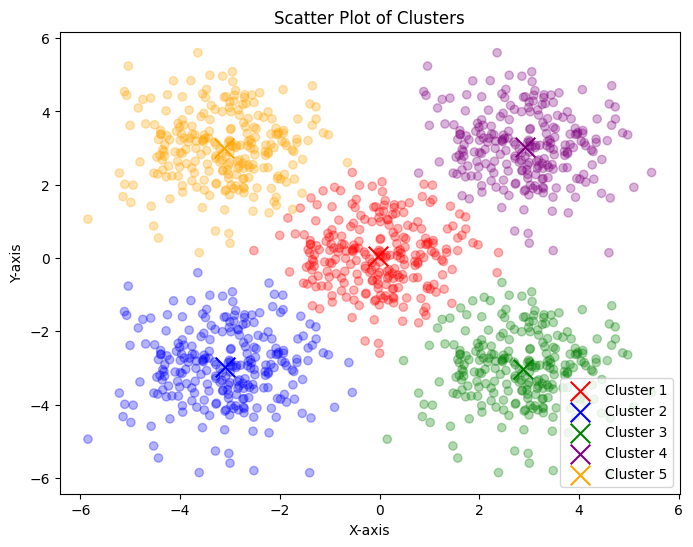

In [18]:
plot_gaus(gclusters, gscores)

In [19]:
n_clusters = 6
n_epochs = 50

hclusters, likelihoods, hscores, sample_likelihoods, history = train_gmm(x, n_clusters, n_epochs)

Epoch:  10 Likelihood:  -5414.353414440308
Epoch:  20 Likelihood:  -5532.404312116262
Epoch:  30 Likelihood:  -5564.1878310075235
Epoch:  40 Likelihood:  -5544.253750864613
Epoch:  50 Likelihood:  -5523.975216281908


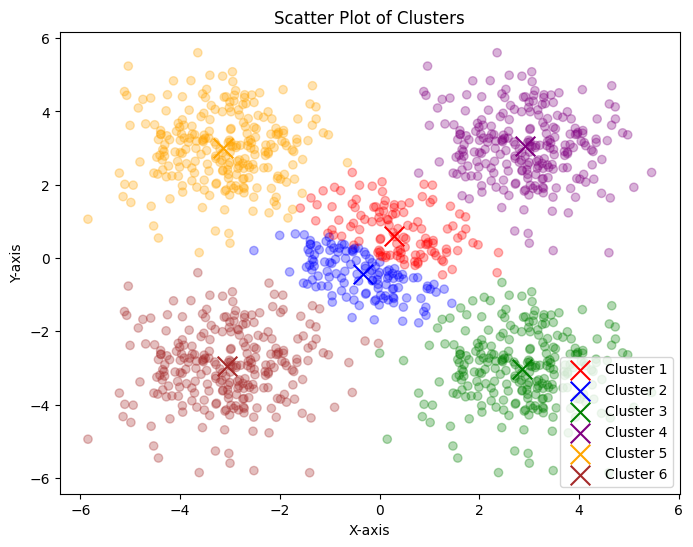

In [20]:
plot_gaus(hclusters, hscores)